In [1]:
# Local
from resources import Tools # type: ignore
from resources import FlowTools # type: ignore

# Math
import numpy as np
from scipy.special import comb
import matplotlib.pyplot as plt

# Data
import cv2 as cv

In [2]:
# Get image from file
file = 'Source/Vary Clouds (South Horizon)/#9 2024-04-08 13.05.13.png'
Img1, Img2 = np.hsplit(cv.imread(file)[:,:,::-1], 2)
imgH, imgW = Img1.shape[:2]

# General
Tools.displaySettings()
order = 2

Mean warp-error-to-goal per coefficient set:   e1x=0.278,   e1y=0.101,   e2x=0.285,   e2y=0.098


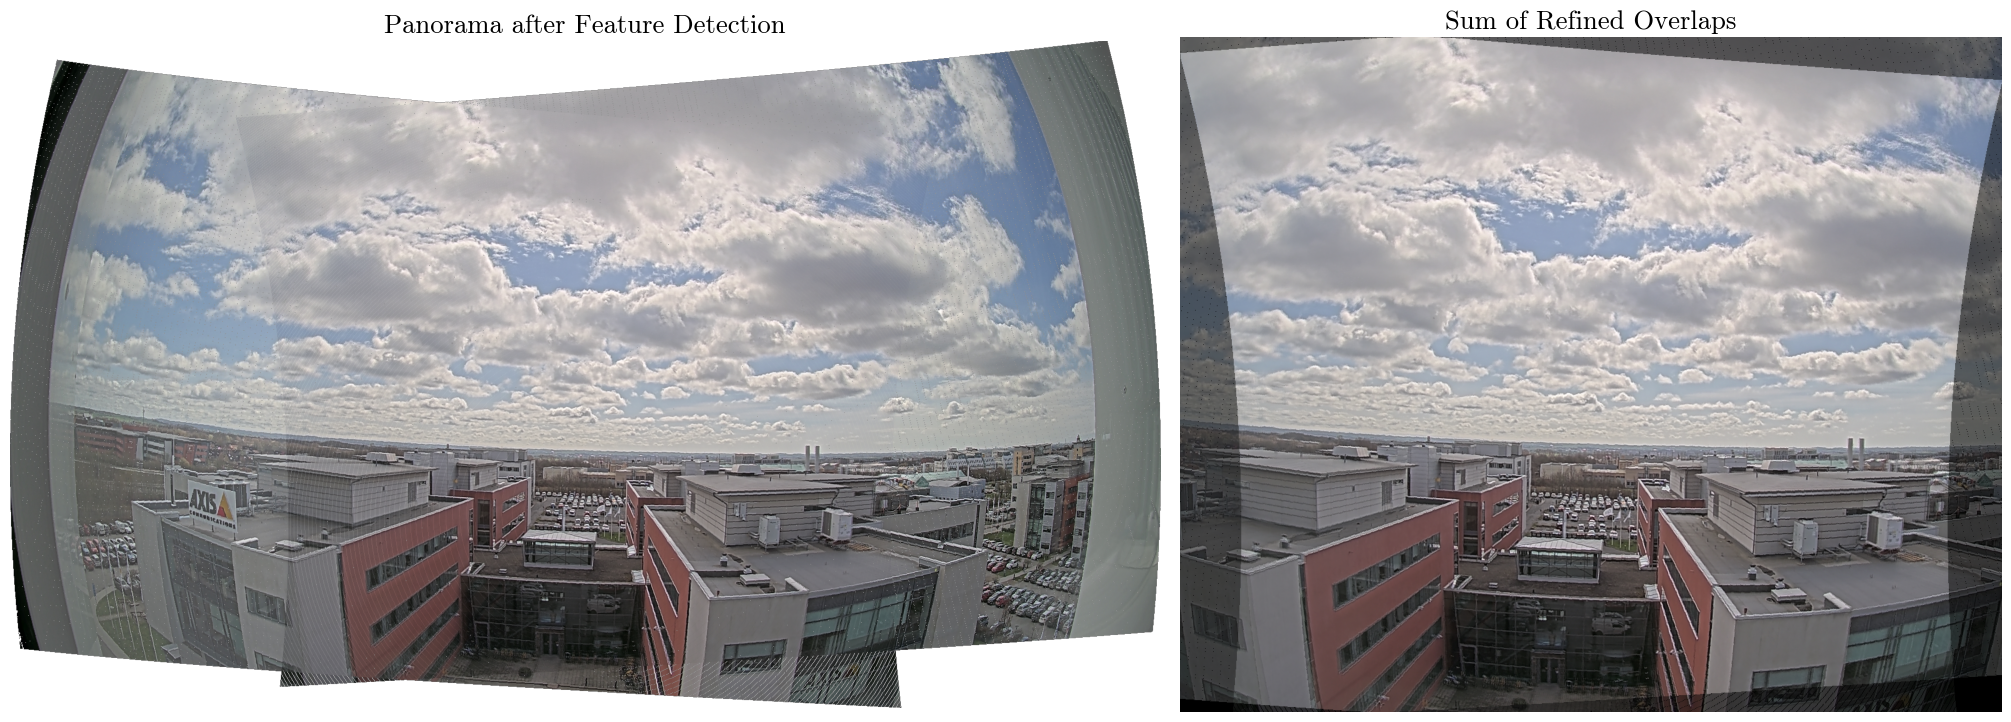

In [3]:
# Detect and match features
featureFinder = cv.SIFT_create()
kp1, des1 = featureFinder.detectAndCompute(cv.cvtColor(Img1[:,:,::-1], cv.COLOR_BGR2GRAY), None)
kp2, des2 = featureFinder.detectAndCompute(cv.cvtColor(Img2[:,:,::-1], cv.COLOR_BGR2GRAY), None)
matcher = cv.BFMatcher(crossCheck=True)
matches = matcher.match(des1, des2)

""" Filter with out matches lower than median similarity, then use RANSAC """
def RANSACMedSim(matches, t=30):
    matches = sorted(matches, key=lambda m: m.distance)[:len(matches)//2]
    p1, p2 = Tools.getMatchPoints(matches, kp1, kp2)
    _, labels = cv.findHomography(p1.T, p2.T, cv.RANSAC, t)
    return [matches[i] for i,l in enumerate(labels) if l == 1]

# Filter matches and determine alignment
filterMatches = RANSACMedSim(matches)
c1 = c2 = np.zeros((Tools.polyTerms2D(order), 2))
p1G, p2G, translation, rotation, center, _ = Tools.globalAlignment(*Tools.getMatchPoints(filterMatches, kp1, kp2))
_, _, c1, c2 = Tools.localAlignment(p1G, p2G, c1, c2, order, 'Powell', 1e-18)

# Apply alignment and blend
p0 = np.array([np.repeat(range(imgW), imgH), np.tile(range(imgH), imgW)])
panorama, _, _, p1, p2 = Tools.mergeAndWarpImages(p0, p0, c1, c2, order, translation, rotation, center, [Img1, Img2])
overlaps, y_min, y_max, x_min, x_max = Tools.refineAndConcatenateOverlaps(p0, p1, p2, [Img1, Img2])
img1, img2 = np.hsplit(overlaps, 2)

# Plot result from feature detection
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), width_ratios=(1.4, 1), constrained_layout=True)
ax1.imshow(panorama/np.max(panorama)); ax1.set_title('Panorama after Feature Detection'); ax1.set_axis_off()
ax2.imshow((img1+img2)/np.max(img1+img2)); ax2.set_title('Sum of Refined Overlaps'); ax2.set_axis_off()

In [4]:
# Optical Flow
dic, _, _ = FlowTools.findBestGPC(img1/np.max(img1), img2/np.max(img2))

117

423

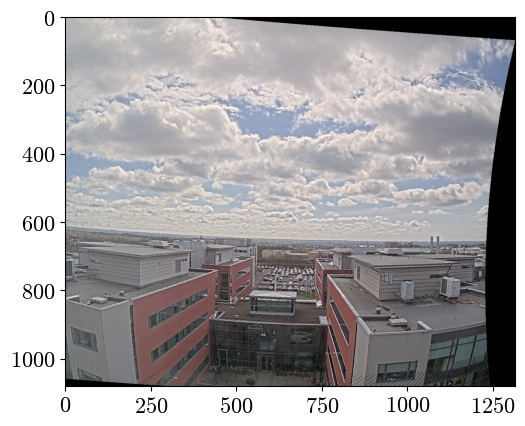

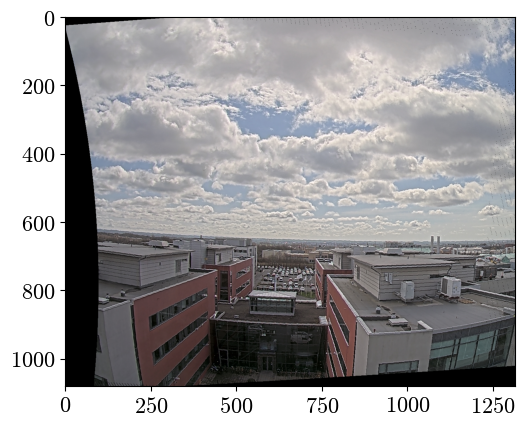

In [5]:
display(y_min, x_min)
plt.figure()
plt.imshow(img1/np.max(img1))

plt.figure()
plt.imshow(img2/np.max(img2))

In [6]:
dic.rollWindowAndFindBestGPC(stepLength=150, windowSize=200, extraWiggle=50)
dic.filterMissMatched(ransac_tol=5)
dic.warp(order)
dic.optimizeWarping(order)
dic.warp(order=order, optimized=True)
c = dic.OptimizeResult.x.reshape(dic.sUV0.shape)
#

In [7]:
def get_polynomial_order(num_coeffs):
    """
    Determine the order of the polynomial based on the number of coefficients.
    """
    order = 0
    while (order + 1) * (order + 2) // 2 <= num_coeffs:
        order += 1
    return order - 1

def transform_polynomial(coeffs, h, k):
    """
    Transform the polynomial coefficients when the origin is shifted by (h, k).
    
    :param coeffs: 1D numpy array where each element is a coefficient for terms x^i y^j.
    :param h: Shift in x direction.
    :param k: Shift in y direction.
    :return: 1D numpy array of the transformed coefficients.
    """
    
    # Calculate the order of the polynomial
    num_coeffs = len(coeffs)
    order = get_polynomial_order(num_coeffs)
    
    # Initialize the new coefficients array
    new_coeffs = np.zeros_like(coeffs)
    
    # Create a mapping from index to (i, j) pairs
    index_to_ij = []
    idx = 0
    for i in range(order + 1):
        for j in range(order + 1 - i):
            index_to_ij.append((j, i))
            idx += 1
    
    # Map the input coefficients to a structured 2D array
    poly_coeffs = np.zeros((order + 1, order + 1))
    for idx, (i, j) in enumerate(index_to_ij):
        poly_coeffs[i, j] = coeffs[idx]

    # Iterate through all possible terms in the original polynomial
    for i in range(order + 1):
        for j in range(order + 1 - i):
            if poly_coeffs[i, j] != 0:
                for m in range(i + 1):
                    for l in range(j + 1):
                        new_coeffs_idx = index_to_ij.index((m, l))
                        new_coeffs[new_coeffs_idx] += (
                            poly_coeffs[i, j] * comb(i, m) * h**(i-m) * comb(j, l) * k**(j-l)
                        )
    
    return new_coeffs

In [20]:
display(y_min, x_min)
d1 = transform_polynomial(c[:,0], -x_min, y_min)
d2 = transform_polynomial(c[:,1], -x_min, y_min)
d = np.array([d1,d2]).T
c01, c02 = c1+d/2, c2-d/2 

display(d,c)

117

423

array([[ 1.573e+01,  4.719e+00],
       [-2.917e-02, -5.105e-03],
       [ 1.477e-05,  2.694e-07],
       [-3.661e-03, -8.106e-03],
       [-6.725e-06,  9.079e-06],
       [ 1.179e-05, -1.478e-06]])

array([[ 6.952e+00,  3.087e+00],
       [-1.589e-02, -5.940e-03],
       [ 1.477e-05,  2.694e-07],
       [-9.265e-03, -3.920e-03],
       [-6.725e-06,  9.079e-06],
       [ 1.179e-05, -1.478e-06]])

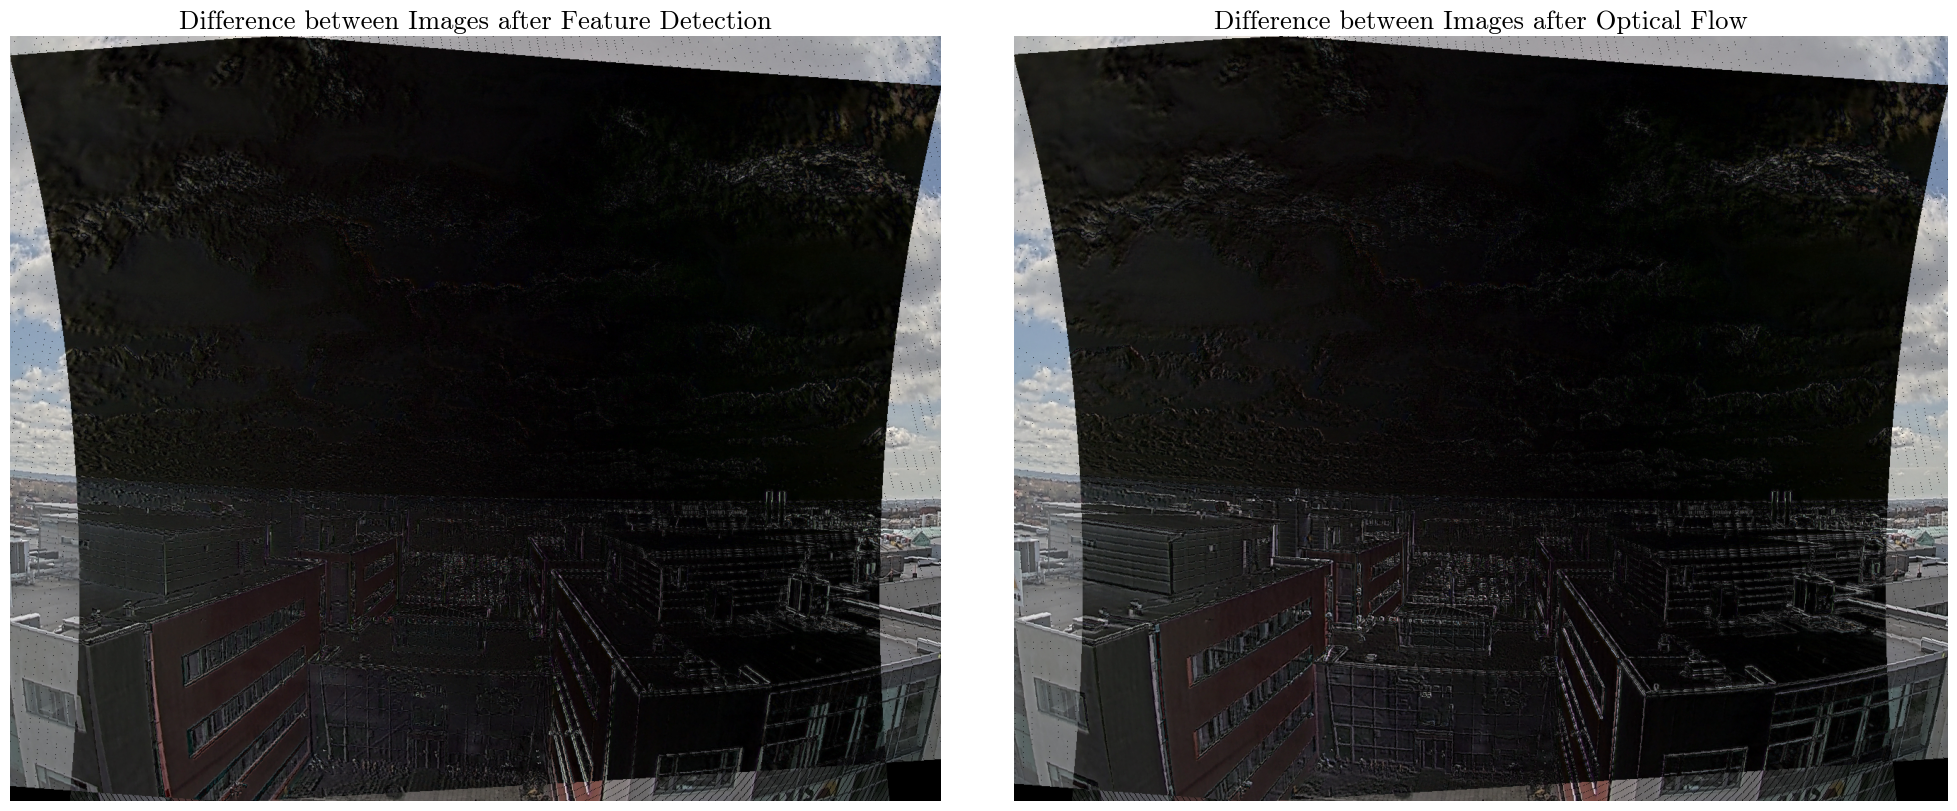

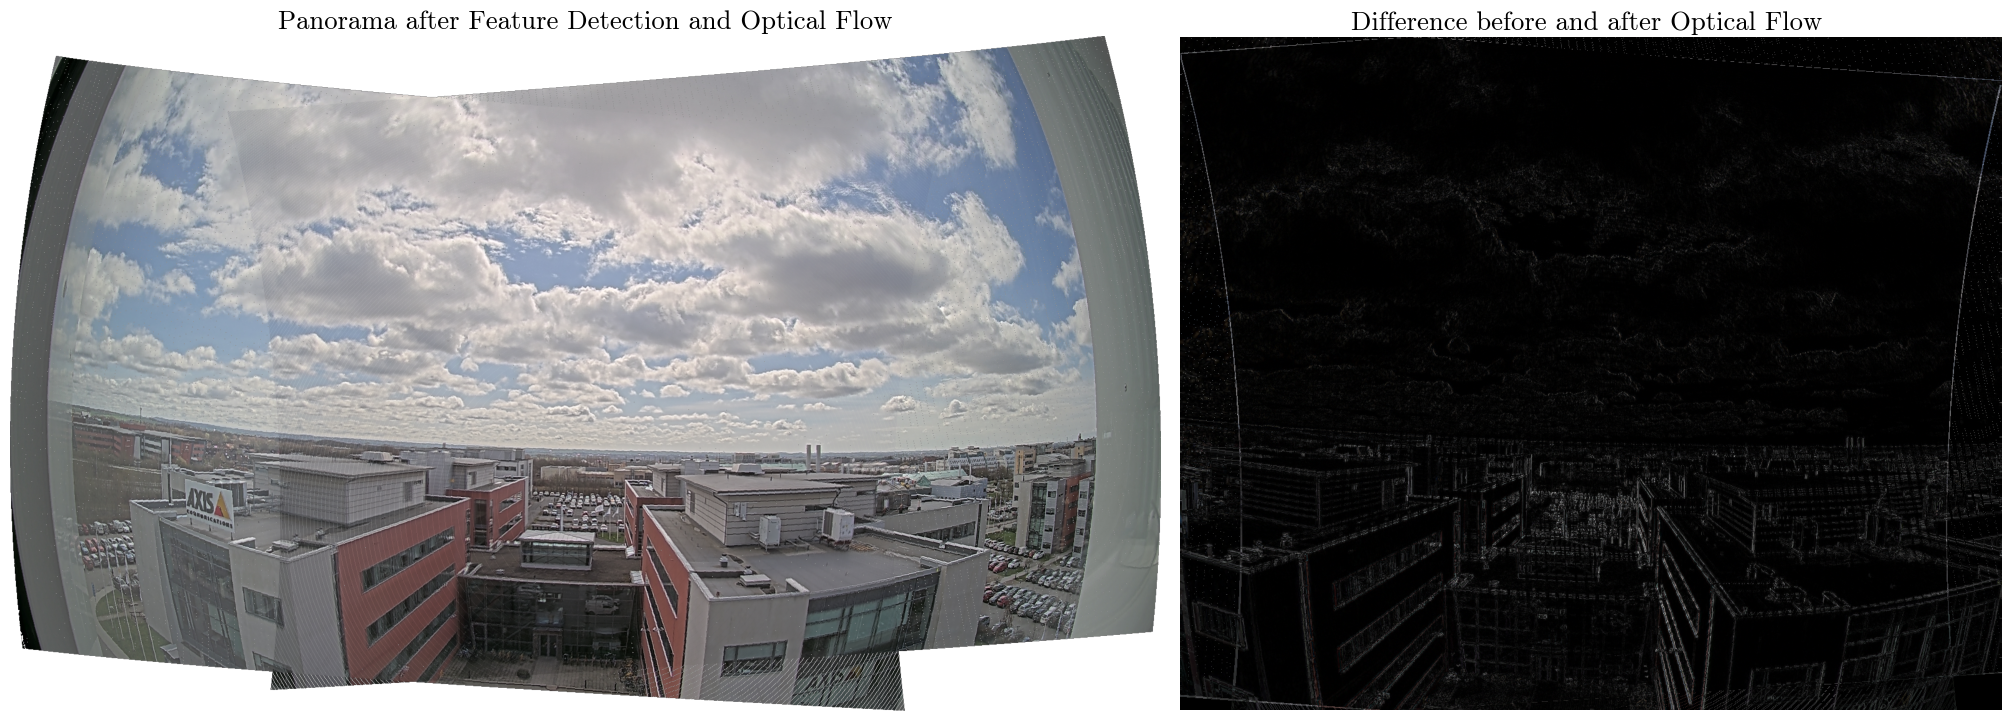

In [21]:
panorama, _, _, p1, p2 = Tools.mergeAndWarpImages(p0, p0, c01, c02, order, translation, rotation, center, [Img1, Img2])
o1O, o2O = np.hsplit(Tools.refineAndConcatenateOverlaps(p0, p1, p2, [Img1, Img2])[0], 2)
i1, i2 = FlowTools.padImages(img1+img2, o1O+o2O); diff = np.abs(i1-i2)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)
ax1.imshow(np.abs(img1-img2)/np.max(np.abs(img1-img2))); ax1.set_title('Difference between Images after Feature Detection'); ax1.set_axis_off()
ax2.imshow(np.abs(o1O-o2O)/np.max(np.abs(o1O-o2O)));  ax2.set_title('Difference between Images after Optical Flow'); ax2.set_axis_off()
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), width_ratios=(1.4, 1), constrained_layout=True)
ax1.imshow(panorama/np.max(panorama)); ax1.set_title('Panorama after Feature Detection and Optical Flow'); ax1.set_axis_off()
ax2.imshow(diff/np.max(diff)); ax2.set_title('Difference before and after Optical Flow '); ax2.set_axis_off()